In [40]:
from formulaic import Formula

In [41]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [25]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [42]:
datos = pd.read_csv('sube-2023.csv')
datos.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO


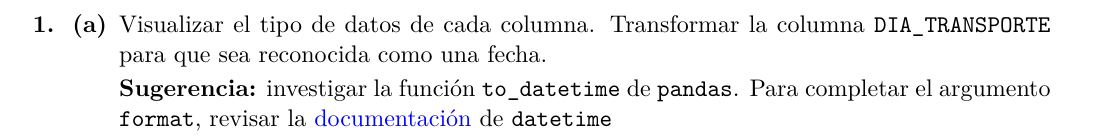

In [27]:
# Convertimos a la columna DIA_TRANSPORTE para que sea reconocida a como una fecha
datos['DIA_TRANSPORTE'] = pd.to_datetime(datos['DIA_TRANSPORTE'], format='%Y-%m-%d')

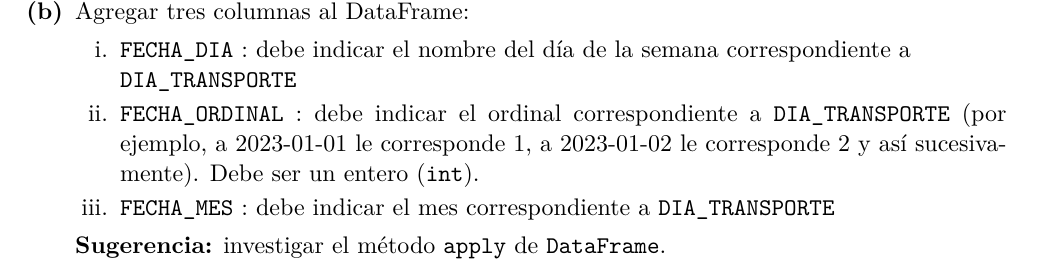

In [28]:
# Agregamos a nuestra DataFrame las columnas indicadas

# Agregamos la columna de fecha_dia con el formato observado en el ejemplo, solamente con 3 carácteres
datos['fecha_dia'] = datos['DIA_TRANSPORTE'].dt.day_name().str[:3]
# Agregamos la columna de fecha_mes en formato 'MM', 2 dígitos para el mes
datos['fecha_mes'] = datos['DIA_TRANSPORTE'].dt.strftime('%m')
# Agregamos la columna de fecha_ordinal indicando el día ordinal del año
datos['fecha_ordinal'] = datos['DIA_TRANSPORTE'].dt.dayofyear

In [29]:
# Tests
# DIA_TRANSPORTE tiene que ser tipo datetime
assert datos['DIA_TRANSPORTE'].dtype == 'datetime64[ns]'

# Dias de la semana
assert datos['fecha_dia'].drop_duplicates().count() == 7 # Tienen que ser 7 dias distintos

# Tiene que haber 365 dias distintos en el año
assert datos['fecha_ordinal'].drop_duplicates().count() == 365


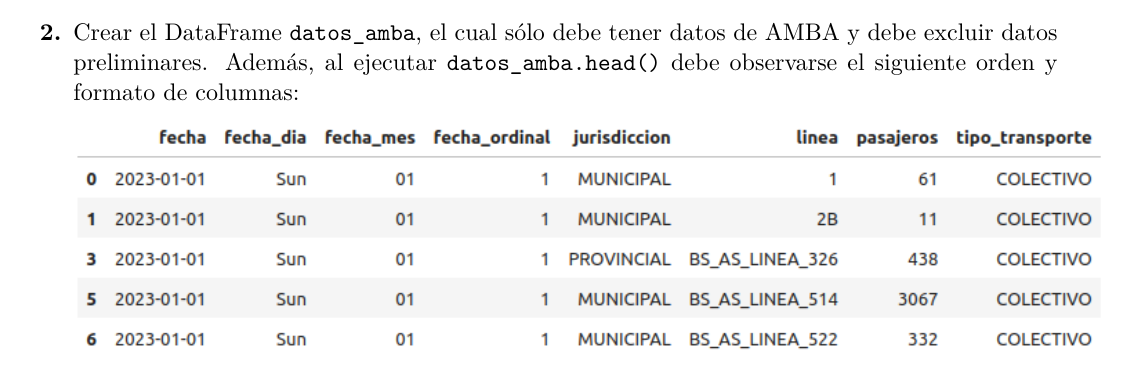

In [168]:
#Creamos un nuevo data frame con los valores a trabajar solicitados.
datos_filtrados = datos[(datos['AMBA'] == 'SI') & (datos['DATO_PRELIMINAR'] == "NO")]

In [169]:
datos_filtrados.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,fecha_dia,fecha_mes,fecha_ordinal
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO,Sun,01,1
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO,Sun,01,1
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO,Sun,01,1
5,2023-01-01,AUTOBUSES BUENOS AIRES S.R.L. – TRANSPORTE LAR...,BS_AS_LINEA_514,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,ALMIRANTE BROWN,3067,NO,Sun,01,1
6,2023-01-01,EL URBANO SRL,BS_AS_LINEA_522,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,LANUS,332,NO,Sun,01,1


In [170]:
#Seleccionamos las columnas correspondientes a visualizar.
column_order  = ['DIA_TRANSPORTE', 'fecha_dia', 'fecha_mes', 'fecha_ordinal', 'JURISDICCION', 'LINEA', 'CANTIDAD', 'TIPO_TRANSPORTE']
datos_filtrados = datos_filtrados[column_order]

In [171]:
#Renombramos las columnas correspondientes y colocamos el formato correcto.
datos_filtrados = datos_filtrados.rename(columns = {"DIA_TRANSPORTE" : "fecha", "CANTIDAD" : "pasajeros"})
#Renombramos las columnas en un formato que sea minúsculas
datos_amba = datos_filtrados.rename(columns = str.lower)

In [172]:
#Visualizamos lo pedido
datos_amba.head()

,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Sun,01,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Sun,01,1,MUNICIPAL,2B,11,COLECTIVO
3,2023-01-01,Sun,01,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
5,2023-01-01,Sun,01,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
6,2023-01-01,Sun,01,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


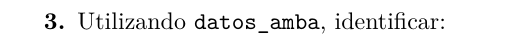

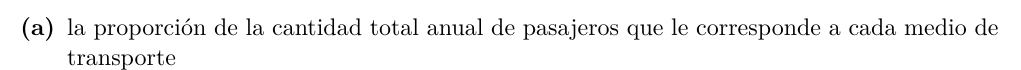

In [162]:
#Realizamos el agrupamiento correspondiente por tipo de transporte y pasajeros, calculando así su proporción
proporcion_transporte = datos_amba.groupby('tipo_transporte')['pasajeros'].sum() / datos_amba['pasajeros'].sum()
print(proporcion_transporte)

tipo_transporte
COLECTIVO    0.837645
SUBTE        0.068097
TREN         0.094258
Name: pasajeros, dtype: float64


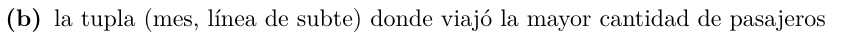

In [173]:
#Creamos un nuevo dataFrame donde sólo estén los datos del tipo de transporte "SUBTE" que se encuentran en el AMBA
subte_data = datos_amba[(datos_amba['tipo_transporte'] == 'SUBTE')]

In [175]:
#Realizamos las tuplas indicadas y sumamos la cantidad de pasajeros, según el mes y la línea
pasajeros_subte_mes = subte_data.groupby(['fecha_mes','linea'])['pasajeros'].sum()
#Localizamos la tupla con el valor máximo en cantidad de pasajeros
max_pasajeros_subte = pasajeros_subte_mes.idxmax()
#Nos quedamos con el valor que posee la mayor cantidad de pasajeros
max_value = pasajeros_subte_mes.max()
#Imprimimos el mes donde concurrió en el SUBTE la mayor cantidad de pasajeros
print(f"El mes con la mayor cantidad de pasajeros fue: {max_pasajeros_subte[0]}")
#Imprimimos la línea donde concurrió en el SUBTE la mayor cantidad de pasajeros
print(f"La línea de subte que tuvo la mayor cantidad de pasajeros fue : {max_pasajeros_subte[1]}")
#Imprimimos el valor máximo que hubo en cantidad de pasajeros
print(max_value)
#Imprimimos la tupla corresponidente indicada
print(max_pasajeros_subte)


El mes con la mayor cantidad de pasajeros fue: 08
La línea de subte que tuvo la mayor cantidad de pasajeros fue : LINEA_B
5227906
('08', 'LINEA_B')


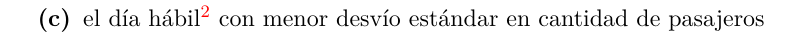

In [156]:
#Realizamos un nuevo DataFrame con los días hábiles a analizar.
días_hábiles = datos_amba[datos_amba['fecha_dia'].isin(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])]
#Realizamos un agrupamiento por días y utilizamos la función std para calcular el desvío entandar en cada día.
desvio_hábiles = días_hábiles.groupby('fecha_dia')['pasajeros'].std()
#Nos quedamos con el valor mínimo.
dia_menor_desvio = desvio_hábiles.idxmin()
print(f"EL día hábil que posee el menor desvío estándar es: {dia_menor_desvio}")

EL día hábil que posee el menor desvío estándar es: Mon


In [103]:
import geopandas as gpd
import matplotlib.pyplot as plt

df = gpd.read_file("argentina.geojson")
datos_mapa = datos[(datos["PROVINCIA"] != "JN") & (datos["TIPO_TRANSPORTE"] == "COLECTIVO")] # Saco los de Jurisdiccion nacional ( no son muy signigicativos en el total 5% aprox)
datos_mapa = datos_mapa.groupby("PROVINCIA").sum("CANTIDAD")
df["nombre"] = df["nombre"].apply(str.upper)
df["cantidad"] = [datos_mapa['CANTIDAD'][provincia] if provincia in datos_mapa.index else 0 for provincia in df["nombre"]]


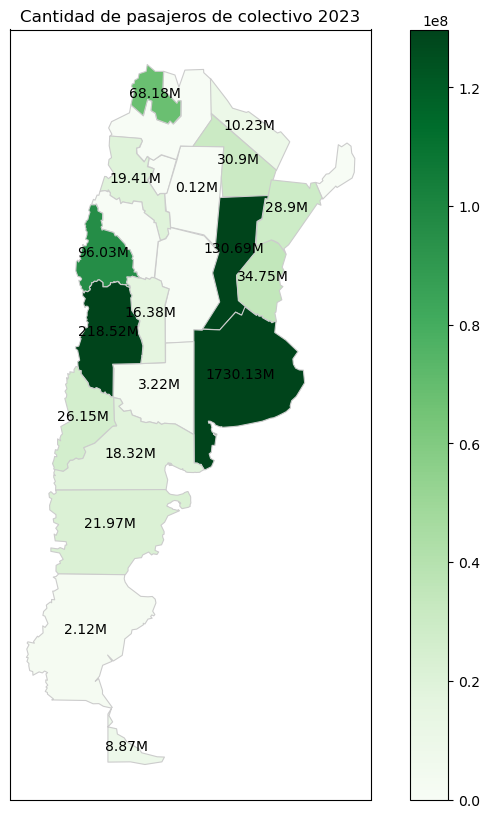

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
df.plot(column='cantidad', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, vmax=datos_mapa["CANTIDAD"].mean())

def million_format(n):
    if (n == 0):
        return ""

    return str(round(n/1000000, 2))+"M"

for i, row in df.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, million_format(row['cantidad']), horizontalalignment='center')
plt.title('Cantidad de pasajeros de colectivo 2023')
plt.show()